# Intro
Loading Spacy requires loading a model as well.
We usually call the result of that spacy.load `nlp`.

In [1]:
import spacy
nlp = spacy.load('en_core_web_md')

We use `nlp` to parse/process the text in a string. It gives us back a Spacy document, which is already parsed into sentences and tokens.

In [2]:
doc = nlp('Erica is typing this. Pieter is watching.')

You can interact with the Spacy document to extract words/sentences. If you don't put list in front it returns a generator. The code below returns the second sentence.

In [3]:
list(doc.sents)[1]

Pieter is watching.

The below code takes the first entity from the Spacy document (which is Erica) - and the label, which it assumes correctly is a person.

In [4]:
doc.ents[0].label_

'PERSON'

Put an underscore after the property for it to return the string of the label rather than the number. If spacy returns a number when you are expecting to see something in text always try an underscore after.

Seeing if it's as smart as me (it isn't, but model en_core_web_trf is)

In [5]:
doc1 = nlp('Her name is may and she is born in june.')
doc1.ents[0].label_

'DATE'

In [6]:
doc

Erica is typing this. Pieter is watching.

In [7]:
doc[1].is_stop

True

In [8]:
[token for token in doc if not token.is_stop]

[Erica, typing, ., Pieter, watching, .]

# TFIDF vectors

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Example

In [10]:
ex_corpus = [
    "Erica is typing. Erica is learning.",
    "Pieter is watching. Erica is doing the thing.",
    "They are having fun."
]

In [11]:
ex_vectorizer = TfidfVectorizer()
ex_tfidf = ex_vectorizer.fit_transform(ex_corpus)
ex_tfidf.todense()

matrix([[0.        , 0.        , 0.59085245, 0.        , 0.        ,
         0.59085245, 0.38844998, 0.        , 0.        , 0.        ,
         0.        , 0.38844998, 0.        ],
        [0.        , 0.35596438, 0.27072008, 0.        , 0.        ,
         0.54144017, 0.        , 0.35596438, 0.35596438, 0.        ,
         0.35596438, 0.        , 0.35596438],
        [0.5       , 0.        , 0.        , 0.5       , 0.5       ,
         0.        , 0.        , 0.        , 0.        , 0.5       ,
         0.        , 0.        , 0.        ]])

In [12]:
ex_vectorizer.get_feature_names_out()

array(['are', 'doing', 'erica', 'fun', 'having', 'is', 'learning',
       'pieter', 'the', 'they', 'thing', 'typing', 'watching'],
      dtype=object)

In [13]:
ex_tfidf.shape

(3, 13)

## Tweets

In [14]:
import pandas as pd

In [15]:
tweets = pd.read_csv('cleantweet.csv')
print(tweets.shape)
tweets.dropna(subset=["base_text"], inplace=True)
print(tweets.shape)
tweets.head()

(41474, 14)
(41425, 14)


Unnamed: 0      tweet_id  author_id                      date  \
0           0  1.454920e+18   18134929  2021-10-31T21:26:29.000Z   
1           1  1.454920e+18   20038272  2021-10-31T21:24:22.000Z   
2           2  1.454900e+18   20038272  2021-10-31T20:15:04.000Z   
3           3  1.454810e+18   20038272  2021-10-31T14:15:10.000Z   
4           4  1.454800e+18   18134929  2021-10-31T13:30:21.000Z   

                                                text      reply_id  \
0  #RACEFORLIFE | Caring cops took on a 17-mile r...           NaN   
1  Calderdale Police can confirm the body of a wo...           NaN   
2  Looking at indecent images of children isn't a...           NaN   
3  Vulnerable people are being abused and trapped...           NaN   
4  @KarenJukes2 @ChevyGuy666 @brumpolice Hi Karen...  1.240000e+18   

   retweet_count  reply_count  like_count  quote_count           police_force  \
0              7            1          30            2   West Midlands Police   
1             13            2           9            2  West Yorkshire Police   
2              0            0           2            0  West Yorkshire Police   
3              5            0           4            0  West Yorkshire Police   
4              0            0           0            0   West Midlands Police   

  tweet_type                                          base_text  \
0      tweet  #RACEFORLIFE | Caring cops took on a 17-mile r...   
1      tweet  Calderdale Police can confirm the body of a wo...   
2      tweet  Looking at indecent images of children isn't a...   
3      tweet  Vulnerable people are being abused and trapped...   
4      reply  @KarenJukes2 @ChevyGuy666 @brumpolice Hi Karen...   

                                         token_tweet  
0  ['#raceforlife', 'caring', 'cops', 'took', '17...  
1  ['calderdale', 'police', 'confirm', 'body', 'w...  
2  ['looking', 'indecent', 'images', 'children', ...  
3  ['vulnerable', 'people', 'abused', 'trapped', ...  
4  ['@karenjukes2', '@chevyguy666', '@brumpolice'...

In [90]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(tweets["base_text"])

In [91]:
tfidf

<41425x34429 sparse matrix of type '<class 'numpy.float64'>'
	with 1051380 stored elements in Compressed Sparse Row format>

In [92]:
import umap
reducer = umap.UMAP(n_components=2, metric="hellinger")

In [93]:
embeddings = reducer.fit_transform(tfidf)

/Users/ericamcgovern/opt/miniconda3/envs/msc/lib/python3.9/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 2776 edges.
It has only fully disconnected 161 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [94]:
embeddings.shape

(41425, 2)

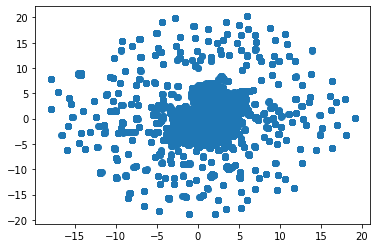

In [95]:
import matplotlib.pyplot as plt
plt.scatter(embeddings[:, 0], embeddings[:, 1])

In [96]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

Loading BokehJS ...

In [97]:
datasource = ColumnDataSource({
    "x": embeddings[:, 0],
    "y": embeddings[:, 1],
    'text': tweets["base_text"]
})
fig = figure(tooltips = [('text', '@text')])
fig.circle("x", "y", source=datasource)
show(fig)

In [98]:
from bokeh.plotting import output_file, save
output_file("tweets.html", mode="inline")
save(fig)

'/Users/ericamcgovern/Documents/Data Analytics and Society/MSc Year 2/GEOG5099M/Data and Code/uk_police_twitter/tweets.html'